In [1]:
import sys
# extending path to be able to import tudaesasII from the parent directory
sys.path.append('../..')

import numpy as np
from numpy import cos, sin, pi
from scipy.linalg import cholesky, eigh

from tudaesasII.beam2d import Beam2D, update_K, update_M, DOF, exx

# number of nodes
n = 301 # keep it odd to have a node at point B
# Material Lastrobe Lescalloy
E = 203.e9 # Pa
rho = 7.83e3 # kg/m3

# damping
c = 350. # N/(m/s)
ku = 5.e7 # N/m
kv = 5.e5 # N/m

m_wheel = 5 # kg
k_wheel = 1.0 # m
Izz_wheel = m_wheel*k_wheel**2
m_airplane = 200 # kg
k_airplane = 5.0 # m
Izz_airplane = m_airplane*k_airplane**2

a = 2.4
b = 1.2
beam_base_y = 0.5
thetas = np.linspace(pi, 0, n) # from point A to point C
R = a*b/np.sqrt((b*cos(thetas))**2 + (a*sin(thetas))**2)
x = R*cos(thetas)
y = beam_base_y + R*sin(thetas)

# cross section properties at given points
dy_A = 0.050 # m
dz_A = 0.040 # m
h_A = 0.003 # m

dy_B = 0.100 # m
dz_B = 0.080 # m
h_B = 0.006 # m

dy_C = dy_A
dz_C = dz_A
h_C = h_A

# creating function for sA(t) = sC(t)
vertical_velocity = -10
v0h = 40 # m/s
vfh = 0
aBump = 0.010 # m
Lr = 200
nbumps = 150

ac = 1/Lr*1/2*(vfh**2 - v0h**2) # constant deceleration rate
tmax = (vfh - v0h)/ac # time until stop
print('ac', ac)
print('tmax', tmax)
dt = 0.001

# tapered beam cross section
dy = np.concatenate((
    np.linspace(dy_A, dy_B, n//2, endpoint=False),
    np.linspace(dy_B, dy_C, n//2+1, endpoint=True)
    ))
dz = np.concatenate((
    np.linspace(dz_A, dz_B, n//2, endpoint=False),
    np.linspace(dz_B, dz_C, n//2+1, endpoint=True)
    ))
h = np.concatenate((
    np.linspace(h_A, h_B, n//2, endpoint=False),
    np.linspace(h_B, h_C, n//2+1, endpoint=True)
    ))

A = 2*dy*h + (dz - 2*h)*h*2
Izz = 1/12*dz*dy**3 - 1/12*(dz-2*h)*(dy-2*h)**3

# getting nodes
x = np.concatenate(([-a], x, [+a])) # adding x coord of wheel nodes
y = np.concatenate(([0], y, [0])) # assing y coord of wheel nodes
ncoords = np.vstack((x ,y)).T
nids = 1000000 + np.arange(ncoords.shape[0])
nid_pos = dict(zip(nids, np.arange(len(nids))))

# nids 1, 2, 3, 4, 5, ....,  n-2, n-1, n (the last is the aicraft)

#from 2 to n-2
n1s = nids[1:-2] # discounting wheel nodes
#from 3 to n-1
n2s = nids[2:-1]

size = (n+2)*DOF # n+2 to account for the two wheel nodes
K = np.zeros((size, size))
M = np.zeros((size, size))
C = np.zeros((size, size))

beams = []
for n1, n2 in zip(n1s, n2s):
    pos1 = nid_pos[n1]
    pos2 = nid_pos[n2]
    x1, y1 = ncoords[pos1]
    x2, y2 = ncoords[pos2]
    A1 = A[pos1-1]
    A2 = A[pos2-1]
    Izz1 = Izz[pos1-1]
    Izz2 = Izz[pos2-1]
    beam = Beam2D()
    beam.interpolation = 'legendre'
    beam.n1 = n1
    beam.n2 = n2
    beam.E = E
    beam.rho = rho
    beam.A1, beam.A2 = A1, A2
    beam.Izz1, beam.Izz2 = Izz1, Izz2
    update_K(beam, nid_pos, ncoords, K)
    update_M(beam, nid_pos, M, lumped=False)
    beams.append(beam)

# adding effect of concentrated aircraft mass into M
pos_aircraft = np.where(np.isclose(y,  b + beam_base_y))[0][0]

# Useful DOF list
# [0, 1, 2] left wheel, ...
# [DOF*pos_aircraft+0, DOF*pos_aircraft+1, DOF*pos_aircraft+1] aircraft
# [-3, -2, -1] right wheel

M[DOF*pos_aircraft+0, DOF*pos_aircraft+0] += m_airplane # u displacement
M[DOF*pos_aircraft+1, DOF*pos_aircraft+1] += m_airplane # v displacement
M[DOF*pos_aircraft+2, DOF*pos_aircraft+2] += Izz_airplane # beta rotation

# adding effect of dashpot on wheel connections
pos_wheel_left1 = np.where(np.isclose(x,  -a) & np.isclose(y,  0))[0][0] # node at left wheel
pos_wheel_left2 = np.where(np.isclose(x,  -a) & np.isclose(y,  beam_base_y))[0][0] # left extremity beam
pos_wheel_right1 = np.where(np.isclose(x,  a) & np.isclose(y,  0))[0][0] # node at right whell
pos_wheel_right2 = np.where(np.isclose(x,  a) & np.isclose(y,  beam_base_y))[0][0] # right extremity beam

# left dashpot stiffness
K[DOF*pos_wheel_left1+0, DOF*pos_wheel_left1+0] += +ku
K[DOF*pos_wheel_left2+0, DOF*pos_wheel_left2+0] += +ku
K[DOF*pos_wheel_left1+0, DOF*pos_wheel_left2+0] += -ku
K[DOF*pos_wheel_left2+0, DOF*pos_wheel_left1+0] += -ku
K[DOF*pos_wheel_left1+1, DOF*pos_wheel_left1+1] += +kv
K[DOF*pos_wheel_left2+1, DOF*pos_wheel_left2+1] += +kv
K[DOF*pos_wheel_left1+1, DOF*pos_wheel_left2+1] += -kv
K[DOF*pos_wheel_left2+1, DOF*pos_wheel_left1+1] += -kv

# left dashpot damping
C[DOF*pos_wheel_left1+1, DOF*pos_wheel_left1+1] += +c
C[DOF*pos_wheel_left2+1, DOF*pos_wheel_left2+1] += +c
C[DOF*pos_wheel_left1+1, DOF*pos_wheel_left2+1] += -c
C[DOF*pos_wheel_left2+1, DOF*pos_wheel_left1+1] += -c

# right dashpot stiffness
K[DOF*pos_wheel_right1+0, DOF*pos_wheel_right1+0] += +ku
K[DOF*pos_wheel_right2+0, DOF*pos_wheel_right2+0] += +ku
K[DOF*pos_wheel_right1+0, DOF*pos_wheel_right2+0] += -ku
K[DOF*pos_wheel_right2+0, DOF*pos_wheel_right1+0] += -ku
K[DOF*pos_wheel_right1+1, DOF*pos_wheel_right1+1] += +kv
K[DOF*pos_wheel_right2+1, DOF*pos_wheel_right2+1] += +kv
K[DOF*pos_wheel_right1+1, DOF*pos_wheel_right2+1] += -kv
K[DOF*pos_wheel_right2+1, DOF*pos_wheel_right1+1] += -kv

# right dashpot damping
C[DOF*pos_wheel_right1+1, DOF*pos_wheel_right1+1] += +c
C[DOF*pos_wheel_right2+1, DOF*pos_wheel_right2+1] += +c
C[DOF*pos_wheel_right1+1, DOF*pos_wheel_right2+1] += -c
C[DOF*pos_wheel_right2+1, DOF*pos_wheel_right1+1] += -c

# mass of left wheel
M[DOF*pos_wheel_left1+0, DOF*pos_wheel_left1+0] += m_wheel # u displacement
M[DOF*pos_wheel_left1+1, DOF*pos_wheel_left1+1] += m_wheel # v displacement
M[DOF*pos_wheel_left1+2, DOF*pos_wheel_left1+2] += Izz_wheel # beta rotation
# mass of right wheel
M[DOF*pos_wheel_right1+0, DOF*pos_wheel_right1+0] += m_wheel # u displacement
M[DOF*pos_wheel_right1+1, DOF*pos_wheel_right1+1] += m_wheel # v displacement
M[DOF*pos_wheel_right1+2, DOF*pos_wheel_right1+2] += Izz_wheel # beta rotation

assert np.allclose(K, K.T)
assert np.allclose(M, M.T)
assert np.allclose(C, C.T)

# NOTE calculating total mass of the system
unit_translation = np.zeros(size)
unit_translation[1::DOF] = 1
mass = unit_translation.T @ M @ unit_translation

# applying boundary conditions
# vA = vC = 0
# uB = 0
known_DOFs = [
        DOF*pos_wheel_left1+1,  # v displacement on left wheel (will be prescribed from soil roughness)
        DOF*pos_wheel_left1+2,  # beta rotation on left wheel (set to zero)
        DOF*pos_aircraft+0,     # u displacement on aircraft node (set to zero)
        DOF*pos_wheel_right1+1, # v displacement on right wheel (will be prescribed from soil roughness)
        DOF*pos_wheel_right1+2, # beta rotation on right wheel (set to zero)
        ]
bu = np.logical_not(np.in1d(np.arange(M.shape[0]), known_DOFs))
bk = np.in1d(np.arange(M.shape[0]), known_DOFs)

Muu = M[bu, :][:, bu]
Mku = M[bk, :][:, bu]
Muk = M[bu, :][:, bk]
Mkk = M[bk, :][:, bk]

Kuu = K[bu, :][:, bu]
Kku = K[bk, :][:, bu]
Kuk = K[bu, :][:, bk]
Kkk = K[bk, :][:, bk]

Cuu = C[bu, :][:, bu]
Cku = C[bk, :][:, bu]
Cuk = C[bu, :][:, bk]
Ckk = C[bk, :][:, bk]

L = cholesky(M, lower=True)
Luu = L[bu, :][:, bu]
Linv = np.linalg.inv(L)
Linvuu = Linv[bu, :][:, bu]

Ktilde = Linv @ K @ Linv.T
Ktildeuu = Ktilde[bu, :][:, bu]

p = 4 # NOTE number of selected modes for the ROM
gamma, Vu = eigh(Ktildeuu, subset_by_index=(0, p-1)) # already gives V[:, i] normalized to 1
omegan = gamma**0.5
eigmodes = np.zeros((size, len(omegan)))
for i in range(eigmodes.shape[1]):
    eigmodes[bu, i] = Linvuu.T @ Vu[:, i]


V = np.zeros((size, p))
V[bu] = Vu

P = np.zeros((size, p))
P[bu] = Vu
Pu = P[bu]

# NOTE using the definition of the modal damping matrix
Dm = P.T @ Linv @ C @ Linv.T @ P

# NOTE obtaining a vector with approximated modal damping ratios from the modal
# damping matrix
zeta = Dm.diagonal()/(2*omegan)

omegad = omegan*np.sqrt(1 - zeta**2)
print('Natural frequencies', omegan[:10])
print('Natural frequencies Hz', omegan[:10]/2/pi)
print('Damped natural frequencies', omegad[:10])

U = Linv.T @ V


ac -4.0
tmax 10.0
Natural frequencies [ 10.65318351  20.37366577 220.38228796 224.60276558]
Natural frequencies Hz [ 1.69550681  3.24256962 35.0749305  35.74664037]
Damped natural frequencies [ 10.65318278  20.37366089 220.28387909 224.45709906]


Prescribed ground excitation
===

Displacement at wheels
---

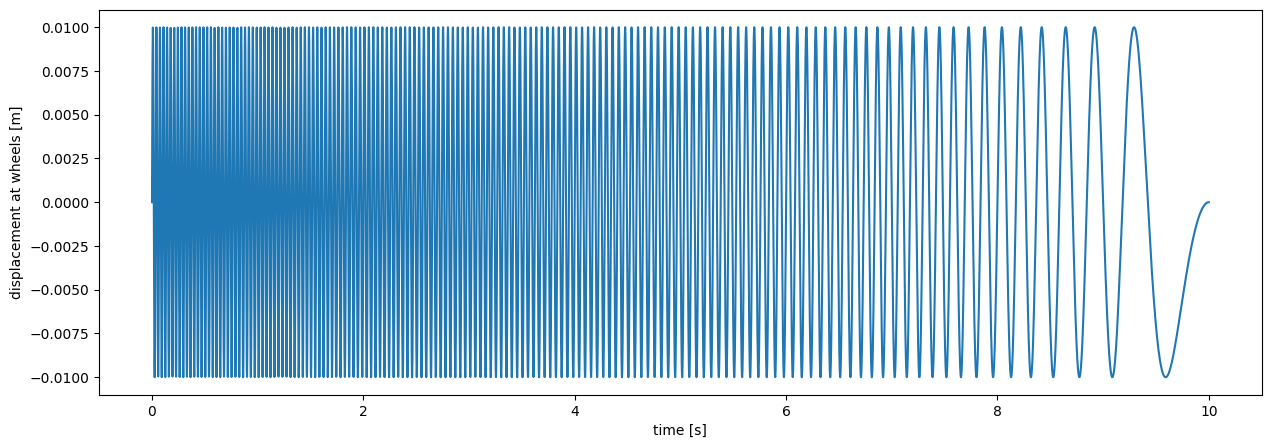

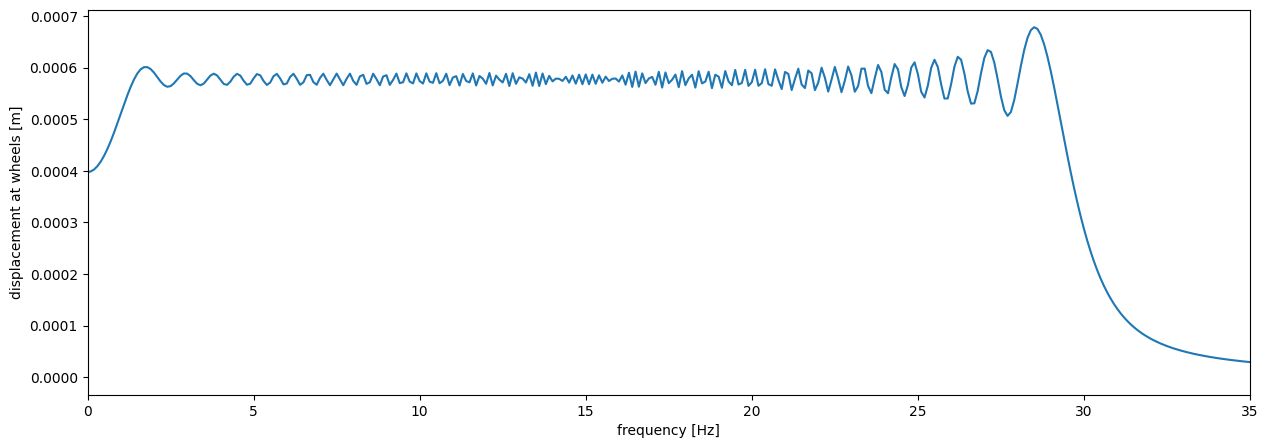

In [2]:
import matplotlib.pyplot as plt

# creating function for sB(t)
vertical_velocity = -10
v0h = 40 # m/s
vfh = 0
aBump = 0.010 # m
Lr = 200
nbumps = 150

ac = 1/Lr*1/2*(vfh**2 - v0h**2) # constant deceleration rate
tmax = (vfh - v0h)/ac # time until stop
dt = 0.001

t = np.linspace(0, tmax, int(tmax/dt))
Nsamples = t.size

# displacements at B as a function of time
s = v0h*t + 1/2*ac*t**2
sA_t = sC_t = aBump*sin(2*nbumps*pi*s/Lr)

plt.figure(figsize=(15,5))
plt.plot(t, sA_t)
plt.xlabel('time [s]')
plt.ylabel('displacement at wheels [m]')
plt.show()

sA_f = np.fft.rfft(sA_t)/(Nsamples//2)
freqs_Hz = np.fft.rfftfreq(Nsamples, d=dt)
plt.figure(figsize=(15,5))
plt.plot(freqs_Hz, np.abs(sA_f))
plt.xlabel('frequency [Hz]')
plt.ylabel('displacement at wheels [m]')
plt.xlim(0, 35)
plt.show()

Oscillatig velocity of the wheels
---

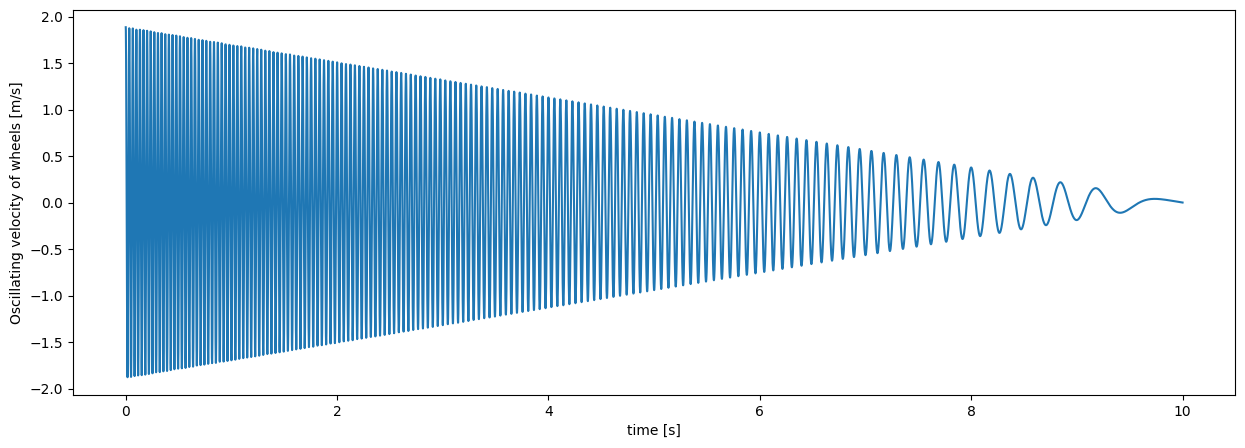

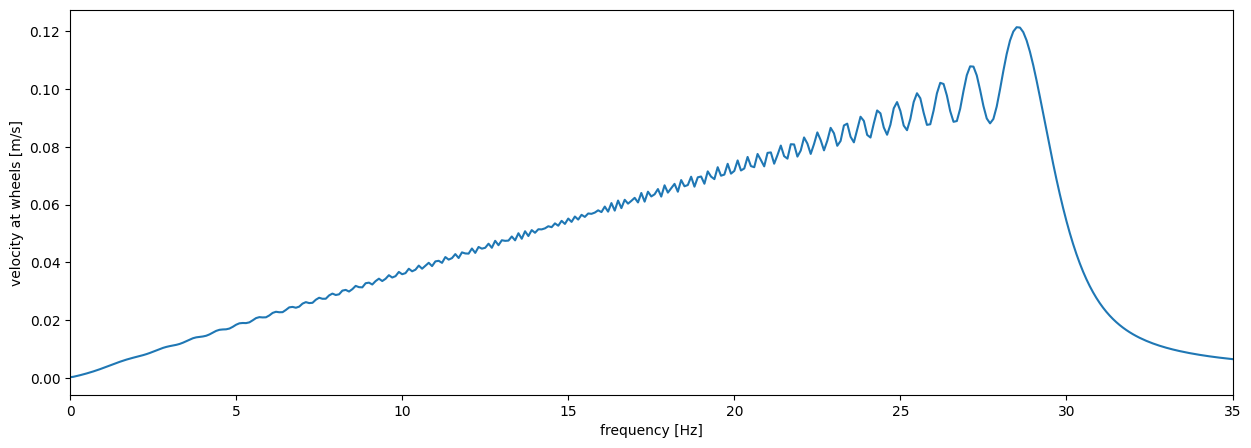

In [3]:
sAdot_t = sCdot_t = 2.0*pi*aBump*nbumps*(ac*t + v0h)*cos(pi*nbumps*t*(ac*t + 2*v0h)/Lr)/Lr
plt.figure(figsize=(15,5))
plt.plot(t, sAdot_t)
plt.xlabel('time [s]')
plt.ylabel('Oscillating velocity of wheels [m/s]')

sAdot_f = np.fft.rfft(sAdot_t)/(Nsamples//2)
freqs_Hz = np.fft.rfftfreq(Nsamples, d=dt)
plt.figure(figsize=(15,5))
plt.plot(freqs_Hz, np.abs(sAdot_f))
plt.xlabel('frequency [Hz]')
plt.ylabel('velocity at wheels [m/s]')
plt.xlim(0, 35)
plt.show()

Oscillating acceleration of wheels
---

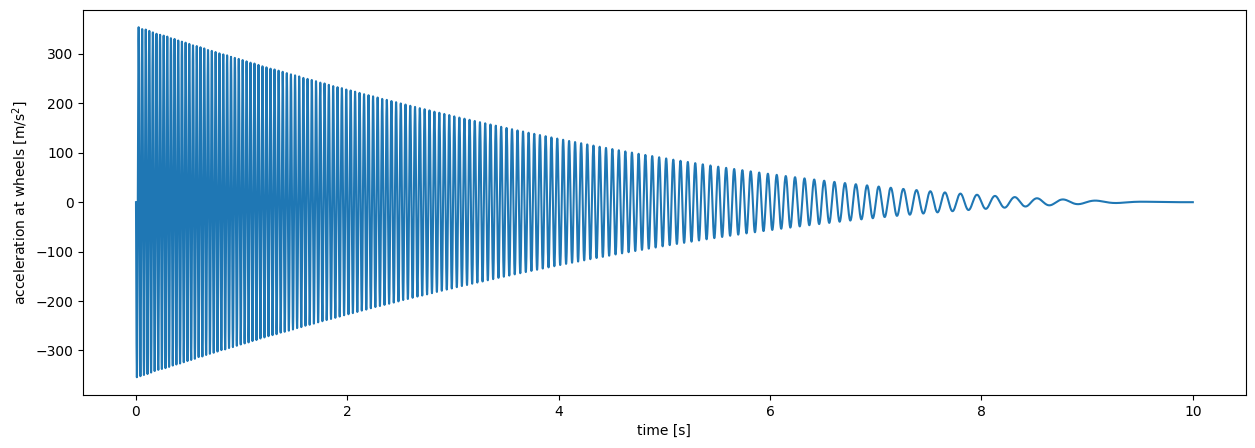

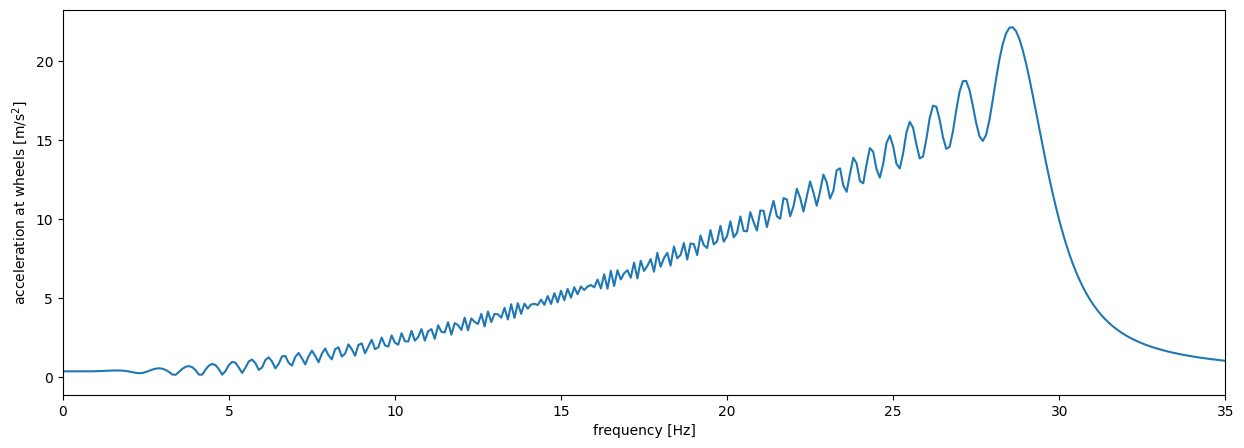

In [4]:
sAddot_t = sCddot_t = pi*aBump*nbumps*(2.0*Lr*ac*cos(pi*nbumps*t*(ac*t + 2*v0h)/Lr) -
        4*pi*nbumps*(1.0*ac*t + v0h)**2*sin(pi*nbumps*t*(ac*t +
            2*v0h)/Lr))/Lr**2
plt.figure(figsize=(15,5))
plt.plot(t, sAddot_t)
plt.xlabel('time [s]')
plt.ylabel('acceleration at wheels [m/s$^2$]')

plt.figure(figsize=(15,5))
sAddot_f = np.fft.rfft(sAddot_t)/(Nsamples//2)
freqs_Hz = np.fft.rfftfreq(Nsamples, d=dt)
plt.plot(freqs_Hz, np.abs(sAddot_f))
plt.xlabel('frequency [Hz]')
plt.ylabel('acceleration at wheels [m/s$^2$]')
plt.xlim(0, 35)
plt.show()

In [5]:
# NOTE using the definition of the modal damping matrix
Dm = P.T @ Linv @ C @ Linv.T @ P

Modal forces in time domain
---

In [6]:
# gravity acceleration
# known_ind = [0, 2, (K.shape[0]-1)-1]
# into uu
g = -9.81 #m/s**2
d2ugdt2 = np.zeros((size, len(t)))
d2ugdt2[1::DOF] = g

# force due to gravity
Fg = M @ d2ugdt2

# displacement vector of known dofs
uk = np.zeros((len(known_DOFs), len(t)))
uk[0] = sA_t # imposed vertical displ at A
uk[3] = sC_t # imposed vertical displ at C

# velocity vector of known dofs
ukdot = np.zeros_like(uk)
ukdot[0] = sAdot_t
ukdot[3] = sCdot_t

# acceleration vector of known dofs
ukddot = np.zeros_like(uk)
ukddot[0] = sAddot_t
ukddot[3] = sCddot_t

# force from prescribed displacements, velocities and accelerations 
Fk = Fg[bu] - Muk @ ukddot - Cuk @ ukdot - Kuk @ uk

# calculating modal forces
fm_t = Pu.T @ Linvuu @ Fk

Plotting modal forces in time domain
---

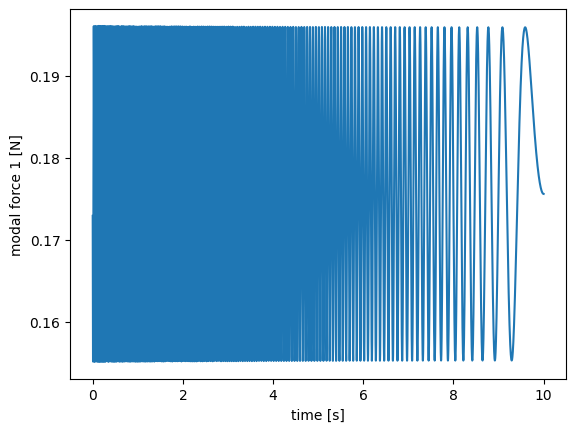

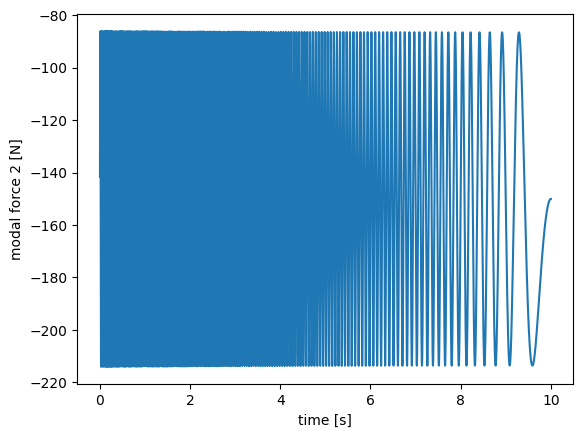

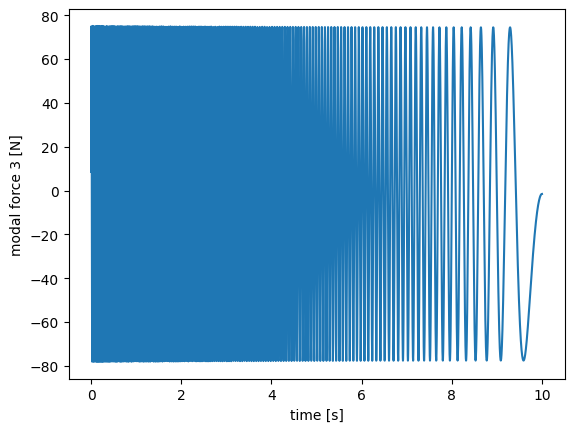

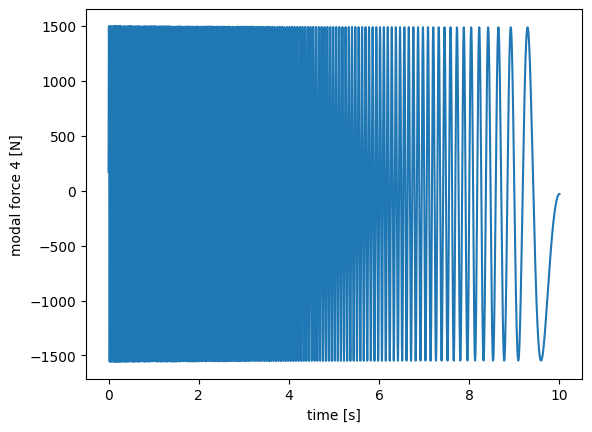

In [7]:
for i in range(p):
    plt.cla()
    plt.plot(t, fm_t[i])
    plt.xlabel('time [s]')
    plt.ylabel('modal force %d [N]' % (i+1))
    plt.show()

Homogeneous solution in time domain
===

In [8]:
u0 = np.zeros(size)
v0 = np.zeros(size)
v0[1::DOF] = vertical_velocity # m/s

r0 = Pu.T @ Luu.T @ u0[bu]
rdot0 = Pu.T @ Luu.T @ v0[bu]

omegad = omegan*np.sqrt(1 - zeta**2)
on = omegan[:, None]
od = omegan*np.sqrt(1 - zeta**2)
od = od[:, None]

rh_t = np.exp(-zeta[:, None]*on*t)*(r0[:, None]*cos(od*t) +
    (rdot0[:, None] + zeta[:, None]*on*r0[:, None])*sin(od*t)/od)


Particular solution
===

Fourier transform: modal forces to frequency domain
---

In [9]:
freqs_Hz = np.fft.rfftfreq(Nsamples, d=dt)
freqs_rad = freqs_Hz*2*pi
fm_f = np.fft.rfft(fm_t, axis=1)/(Nsamples//2)

Plotting modal forces in frequency domain
---

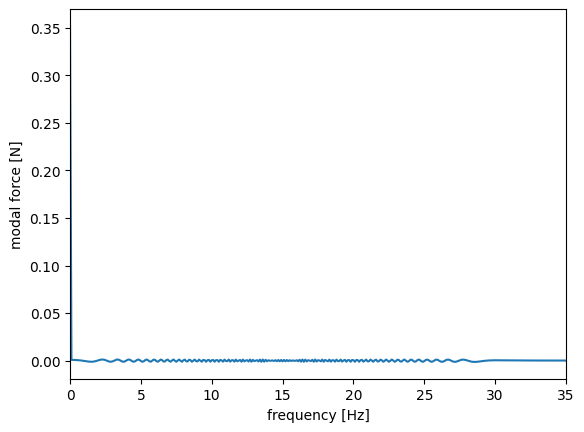

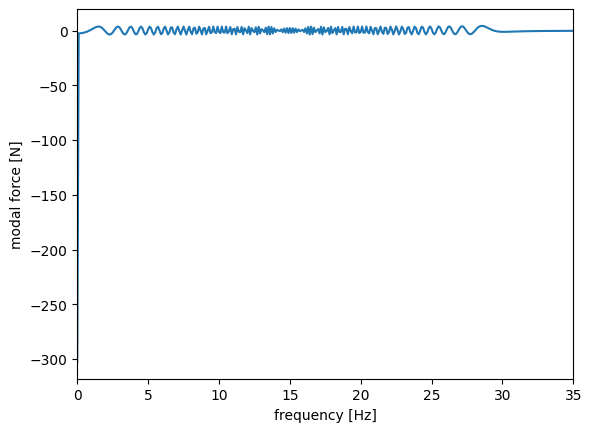

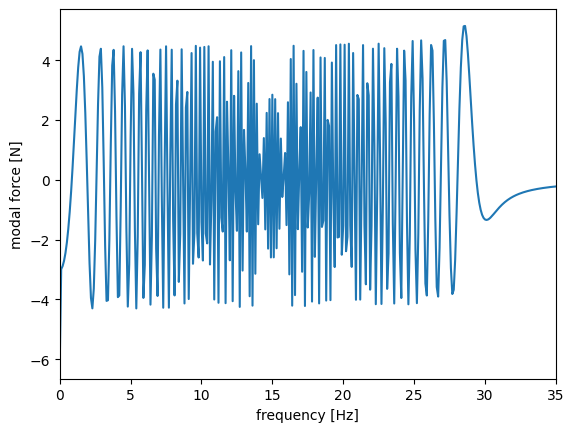

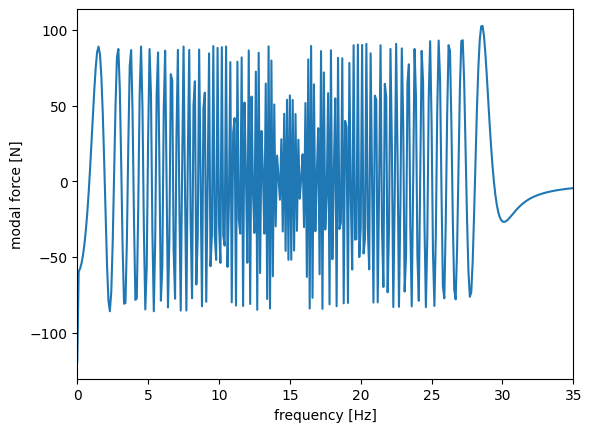

In [18]:
for i in range(p):
    plt.cla()
    plt.plot(freqs_Hz.real, fm_f[i].real)
    plt.xlim(0, 35)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('modal force [N]')
    plt.show()

Frequency Response Function
---

In [11]:
def H(zeta, omegan, omegaf):
    """NOTE: all frequencies must be in rad/s
    """
    return ((omegan**2 - omegaf**2) - 1j*(2*zeta*omegan*omegaf))/((omegan**2 - omegaf**2)**2 + (2*zeta*omegan*omegaf)**2)


Calculating modal displacements in the frequency domain
---

In [12]:
r_f = H(zeta[:, None], omegan[:, None], freqs_rad)*fm_f

Inverse Fourier transform: modal displacement to time domain
---

In [13]:
rp_t = np.fft.irfft(r_f*(Nsamples//2), n=Nsamples)

Superimposing with homogeneous solution in time domain
---

In [14]:
r_t = rh_t + rp_t

Calculating displacements in the physical coordinates in time domain
---

In [15]:
uu_t = Linvuu.T @ Pu @ r_t

u_t = np.zeros((size, Nsamples))
u_t[bu] = uu_t

Calculating stresses
---

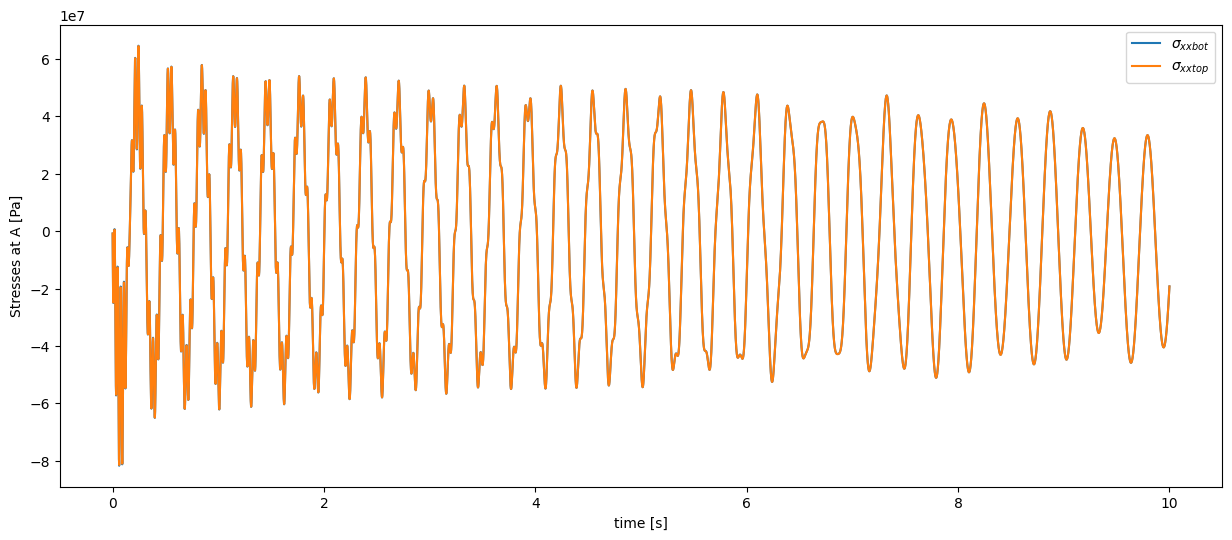

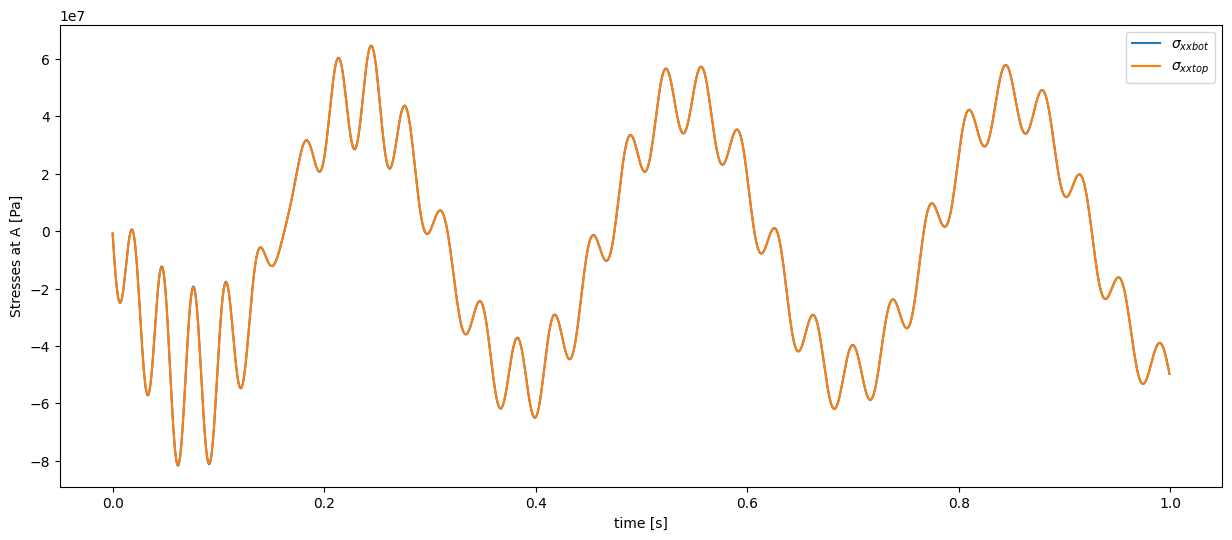

In [16]:
# stresses at A
uA = u_t[3:9, :]
beamA = beams[0]
plt.figure(figsize=(15, 6))
exx_bot_A = exx(beamA, -dy_A/2, -1, *uA)
exx_top_A = exx(beamA, +dy_A/2, -1, *uA)
sigma_bot_A = E*exx_bot_A
sigma_top_A = E*exx_top_A
plt.plot(t, sigma_bot_A, label='${\\sigma_{xx}}_{bot}$')
plt.plot(t, sigma_top_A, label='${\\sigma_{xx}}_{top}$')
plt.xlabel('time [s]')
plt.ylabel('Stresses at A [Pa]')
plt.legend()

plt.figure(figsize=(15, 6))
tzoom = 1
check = t <= tzoom
plt.plot(t[check], sigma_bot_A[check], label='${\\sigma_{xx}}_{bot}$')
plt.plot(t[check], sigma_top_A[check], label='${\\sigma_{xx}}_{top}$')
plt.xlabel('time [s]')
plt.ylabel('Stresses at A [Pa]')
plt.legend()
plt.show()

Calculating the reaction forces
---

Text(0, 0.5, 'Reaction force at wheels [N]')

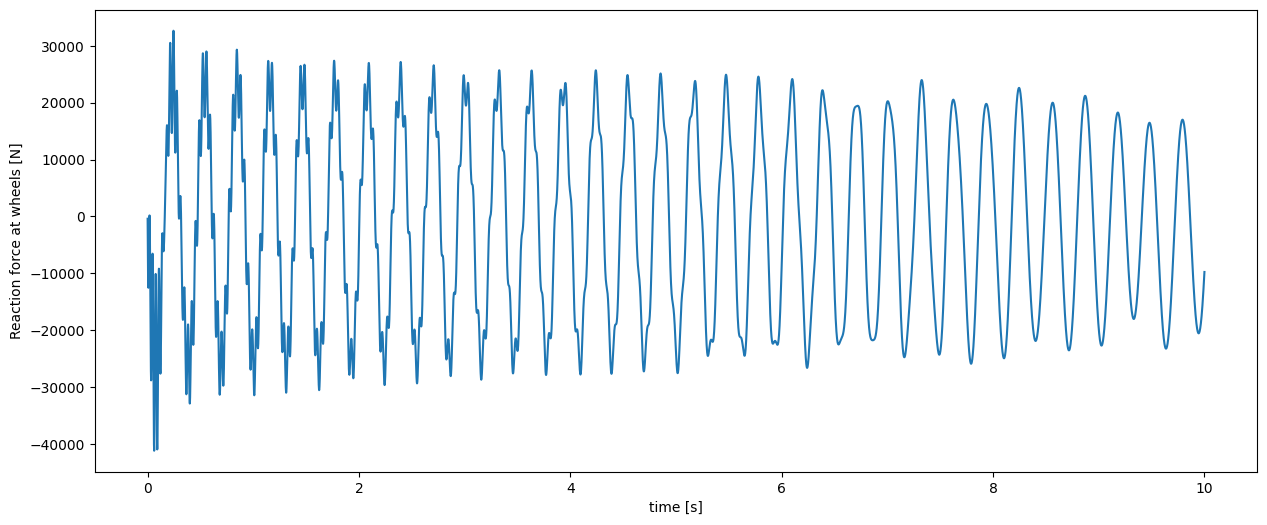

In [20]:
Kku = K[bk, :][:, bu]
Kkk = K[bk, :][:, bk]

Fk = - Kku @ u_t[bu] - Kkk @ u_t[bk] # TODO add influence of massa and damping

plt.figure(figsize=(15, 6))
plt.plot(t, Fk[0])
plt.xlabel('time [s]')
plt.ylabel('Reaction force at wheels [N]')
# plt.legend()